# Cryptocurrency Trader Agent

### UCB MIDS 2017 Winter Capstone Project
#### Ramsey Aweti, Shuang Chan, GuangZhi(Frank) Xie, Jason Xie

### Global Variables

In [1]:
import random 
random.seed(3456)

In [2]:
num_coins_per_order = 0 #0 means buy/sell all per order
recent_k = 500

External States: ["current_price", "rolling_mean", "rolling_std", "cross_upper_band", "cross_lower_band", "upper_band", "lower_band", "price_over_sma"]

Internal States: ["coin", "cash", "total_value", "is_holding_coin", "return_since_entry"]

## ETH

In [3]:
coin_name = 'ethereum'

### Benchmarks

In [37]:
from v2 import run_benchmarks

In [38]:
run_benchmarks.run_bollingerband_agent(
    coin_name=coin_name, num_coins_per_order = num_coins_per_order, recent_k=recent_k)

Final holdings: 0.00 coins, 2035.80 cash, 2035.80 current value, 103.58 percent returns


103.57974920499998

In [39]:
run_benchmarks.run_random_agent(coin_name=coin_name, num_coins_per_order = num_coins_per_order, recent_k=recent_k)

Final holdings: 2.20 coins, 0.03 cash, 650.67 current value, -34.93 percent returns


-34.933448188999947

In [40]:
run_benchmarks.run_alwaysbuy_agent(coin_name=coin_name, num_coins_per_order = num_coins_per_order, recent_k=recent_k)

Final holdings: 69.43 coins, 0.00 cash, 20522.98 current value, 1952.30 percent returns


1952.297967623

### DDQN Agent

In [4]:
from v2.ddqn_agent import DDQNAgent

Using TensorFlow backend.


In [9]:
eth_agent = DDQNAgent(coin_name=coin_name, recent_k = recent_k, num_coins_per_order = num_coins_per_order, 
                      epsilon_min = 0.01,
                      external_states = ["current_price"],
                      internal_states = ["is_holding_coin"], verbose = False)

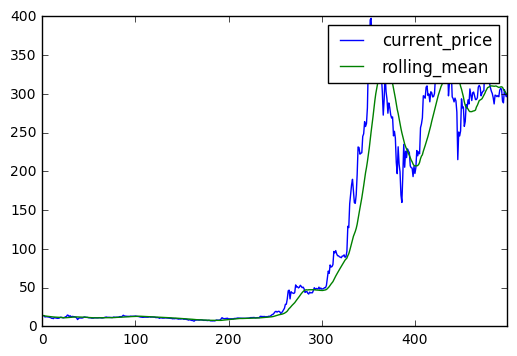

In [7]:
eth_agent.plot_env(states_to_plot=["current_price", "rolling_mean"])

In [8]:
eth_agent.train(num_episodes=1)

Action start Action.SELL Total value before action 1000.0
original coin 0.0 original cash 1000 price 14.1174
coin to sell 0.0 coin now 0.0 cash now 1000.0
Action end: Action.HOLD Reward: 0.0
Action start Action.SELL Total value before action 1000.0
original coin 0.0 original cash 1000.0 price 13.6719
coin to sell 0.0 coin now 0.0 cash now 1000.0
Action end: Action.HOLD Reward: 0.0
Action start Action.BUY Total value before action 1000.0
original coin 0.0 original cash 1000.0 price 14.0693
coin to buy 71.0767 coin now 71.0767 cash now 0.000584689999982
Action end: Action.BUY Reward: -9.90098431
Action start Action.SELL Total value before action 856.3539893
original coin 71.0767 original cash 0.000584689999982 price 12.0483
coin to sell 71.0767 coin now 0.0 cash now 856.3539893
Action end: Action.SELL Reward: -143.6460107
Action start Action.BUY Total value before action 856.3539893
original coin 0.0 original cash 856.3539893 price 12.726
coin to buy 67.2916 coin now 67.2916 cash now 0.0

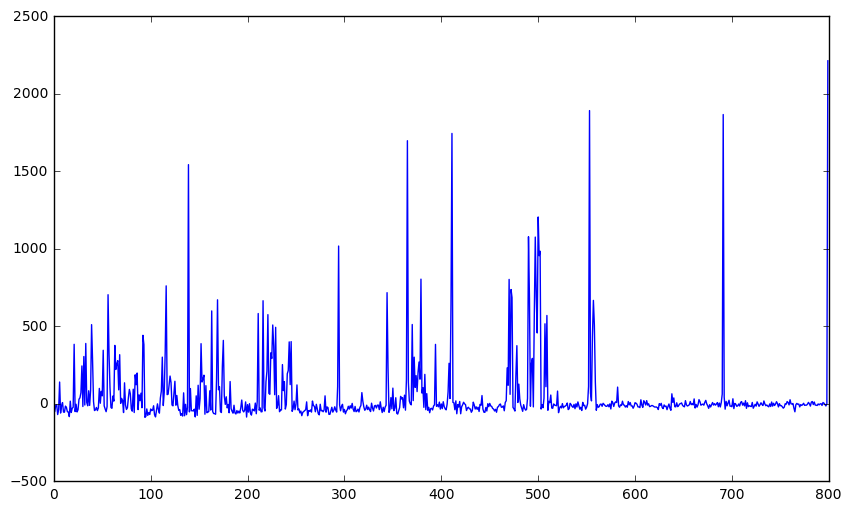

In [33]:
eth_agent.plot_cum_returns()

In [36]:
eth_agent.test(epsilon=0.018)

Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.SELL
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Acti

## Numeraire

In [41]:
coin_name = 'numeraire'
recent_k = 150

### Benchmarks

In [42]:
from v2 import run_benchmarks

In [43]:
run_benchmarks.run_bollingerband_agent(
    coin_name=coin_name, num_coins_per_order = num_coins_per_order, recent_k=recent_k)

Final holdings: 45.99 coins, 0.00 cash, 490.33 current value, -50.97 percent returns


-50.967267061999991

In [44]:
run_benchmarks.run_random_agent(coin_name=coin_name, num_coins_per_order = num_coins_per_order, recent_k=recent_k)

Final holdings: 0.00 coins, 371.06 cash, 371.06 current value, -62.89 percent returns


-62.893776052000064

In [45]:
run_benchmarks.run_alwaysbuy_agent(coin_name=coin_name, num_coins_per_order = num_coins_per_order, recent_k=recent_k)

Final holdings: 28.25 coins, 0.00 cash, 301.19 current value, -69.88 percent returns


-69.880900918000009

### DDQN Agent

In [24]:
from v2.ddqn_agent import DDQNAgent

In [46]:
numeraire_agent = DDQNAgent(coin_name=coin_name, recent_k = recent_k, num_coins_per_order = num_coins_per_order, epsilon_min = 0.01,
                     external_states = ["current_price"],
                     internal_states = ["is_holding_coin"])

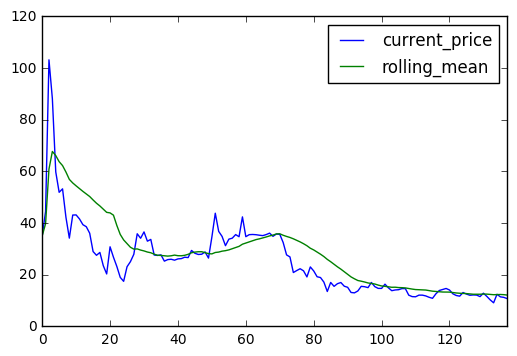

In [47]:
numeraire_agent.plot_env(states_to_plot=["current_price", "rolling_mean"])

In [48]:
numeraire_agent.train(num_episodes=800)

episode: 1/800, returns: -87.567676393, epsilon: 1.0
episode: 2/800, returns: -44.074183275, epsilon: 0.99
episode: 3/800, returns: -81.634803276, epsilon: 0.99
episode: 4/800, returns: -62.72623911, epsilon: 0.99
episode: 5/800, returns: -61.415911928, epsilon: 0.98
episode: 6/800, returns: -82.463056948, epsilon: 0.98
episode: 7/800, returns: -29.086003222, epsilon: 0.97
episode: 8/800, returns: -76.681728845, epsilon: 0.97
episode: 9/800, returns: -88.514103033, epsilon: 0.96
episode: 10/800, returns: -83.077881614, epsilon: 0.96
episode: 11/800, returns: -80.18355821, epsilon: 0.95
episode: 12/800, returns: 56.264837619, epsilon: 0.95
episode: 13/800, returns: -72.897842201, epsilon: 0.94
episode: 14/800, returns: -75.680374962, epsilon: 0.94
episode: 15/800, returns: -32.469070103, epsilon: 0.93
episode: 16/800, returns: 164.162742136, epsilon: 0.93
episode: 17/800, returns: -89.578237025, epsilon: 0.92
episode: 18/800, returns: -82.647033781, epsilon: 0.92
episode: 19/800, return

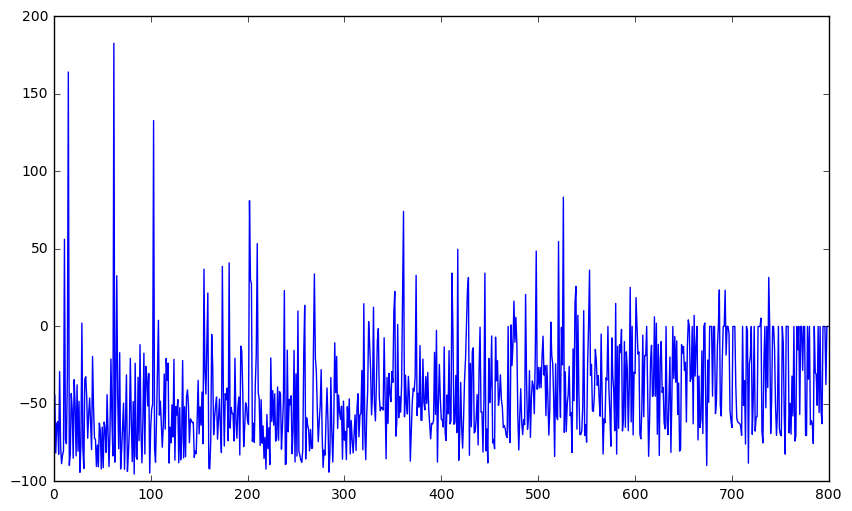

In [49]:
numeraire_agent.plot_cum_returns()

In [50]:
numeraire_agent.test(epsilon=0)

Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Acti

## Qtum

In [52]:
coin_name = 'qtum'

### Benchmarks

In [7]:
from v2 import run_benchmarks

In [20]:
run_benchmarks.run_bollingerband_agent(
    coin_name=coin_name, num_coins_per_order = num_coins_per_order, recent_k=recent_k)

Final holdings: 156.05 coins, 0.00 cash, 1594.37 current value, 59.44 percent returns


59.436512891000007

In [21]:
run_benchmarks.run_random_agent(coin_name=coin_name, num_coins_per_order = num_coins_per_order, recent_k=recent_k)

Final holdings: 0.00 coins, 598.35 cash, 598.35 current value, -40.17 percent returns


-40.165183342999967

In [22]:
run_benchmarks.run_alwaysbuy_agent(coin_name=coin_name, num_coins_per_order = num_coins_per_order, recent_k=recent_k)

Final holdings: 87.16 coins, 0.00 cash, 890.46 current value, -10.95 percent returns


-10.953841487999989

### DDQN Agent

In [23]:
from v2.ddqn_agent import DDQNAgent

In [53]:
qtum_agent = DDQNAgent(coin_name=coin_name, recent_k = recent_k, num_coins_per_order = num_coins_per_order, epsilon_min = 0.01,
                     external_states = ["current_price"],
                     internal_states = ["is_holding_coin"])

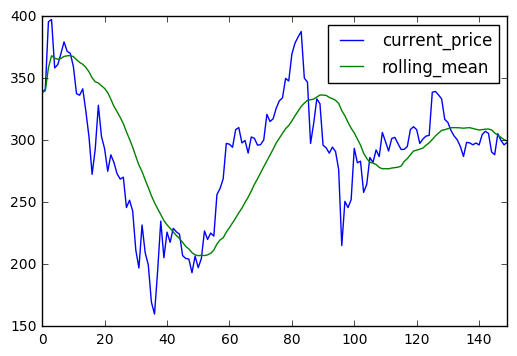

In [9]:
qtum_agent.plot_env(states_to_plot=["current_price", "rolling_mean"])

In [54]:
qtum_agent.train(num_episodes=800)

episode: 1/800, returns: 33.898018572, epsilon: 1.0
episode: 2/800, returns: -1.764352118, epsilon: 0.99
episode: 3/800, returns: 99.646754888, epsilon: 0.99
episode: 4/800, returns: -8.220111279, epsilon: 0.99
episode: 5/800, returns: 9.579789164, epsilon: 0.98
episode: 6/800, returns: -57.443705623, epsilon: 0.98
episode: 7/800, returns: 14.718703269, epsilon: 0.97
episode: 8/800, returns: -60.472150866, epsilon: 0.97
episode: 9/800, returns: -67.059726199, epsilon: 0.96
episode: 10/800, returns: -54.527598565, epsilon: 0.96
episode: 11/800, returns: -64.265838701, epsilon: 0.95
episode: 12/800, returns: -70.194641029, epsilon: 0.95
episode: 13/800, returns: -57.492536812, epsilon: 0.94
episode: 14/800, returns: -5.420029447, epsilon: 0.94
episode: 15/800, returns: -38.789611951, epsilon: 0.93
episode: 16/800, returns: -67.249743773, epsilon: 0.93
episode: 17/800, returns: 12.010118239, epsilon: 0.92
episode: 18/800, returns: -6.975604937, epsilon: 0.92
episode: 19/800, returns: -52.

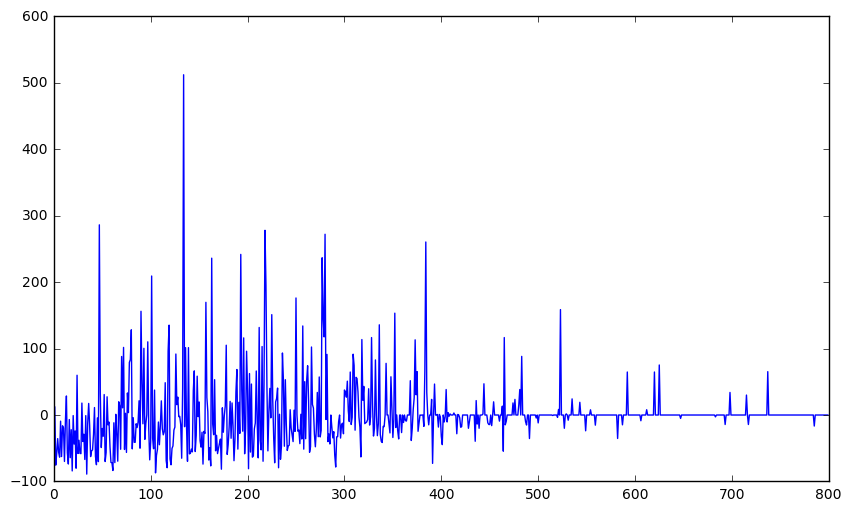

In [26]:
qtum_agent.plot_cum_returns()

In [27]:
qtum_agent.test(epsilon=0)

Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Acti